# Fama French Simulation

In [30]:
#import all the necessary libraries
import yfinance as yf
import datetime as dt
import pandas_datareader as web
import statsmodels.api as sm
import pandas as pd
from matplotlib import pyplot as plt

Read the CSV file ff_factors. This file is little different from the file available at the website as i have modified it to my preference

In [31]:
ff_factors=pd.read_csv('ff_factors.csv',index_col='Month')

In [32]:
#changing the month column to datetime index for example previously an element was like 198006 that is now 1980-06
ff_factors.index = pd.to_datetime(ff_factors.index, format= '%Y%m')
#adding the last date of the month so that it is complatible with the returns of a stock that we will calculate
#later in the code
ff_factors.index = ff_factors.index + pd.offsets.MonthEnd()
#changing all the elements to float data type
ff_factors = ff_factors.astype(float)
#making all the elements. from percentage to decimals to make it compatible with returns of the stock
ff_factors['Mkt-RF']=ff_factors['Mkt-RF'].div(100)
ff_factors['RF']=ff_factors['RF'].div(100)
ff_factors['SMB']=ff_factors['SMB'].div(100)
ff_factors['HML']=ff_factors['HML'].div(100)
ff_factors

,Mkt-RF,SMB,HML,RF
Month,,,,
1926-07-31,0.0296,-0.0230,-0.0287,0.0022
1926-08-31,0.0264,-0.0140,0.0419,0.0025
1926-09-30,0.0036,-0.0132,0.0001,0.0023
1926-10-31,-0.0324,0.0004,0.0051,0.0032
1926-11-30,0.0253,-0.0020,-0.0035,0.0031
...,...,...,...,...
2021-02-28,0.0278,0.0211,0.0708,0.0000
2021-03-31,0.0308,-0.0248,0.0740,0.0000
2021-04-30,0.0493,-0.0309,-0.0074,0.0000


<AxesSubplot:xlabel='Month'>

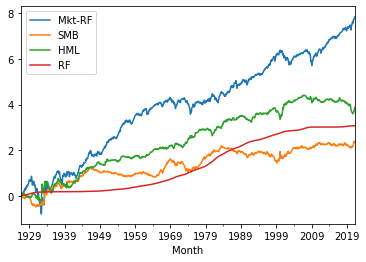

In [33]:
ff_factors_cum = ff_factors.cumsum()
ff_factors_cum.plot.line()

# Apple Stock Simulation

In [34]:
#getting stock information
stock = yf.Ticker("AAPL")#one can change the ticker also to get a fama french simulation for other stocks also
hist = stock.history(period="max", auto_adjust=True, rounding=False)
price = hist[["Close"]]
#resampling the stock daily information to monthly stock information
monthly_price = price.resample('BM').last()

# calculate monthly returns
monthly_returns = monthly_price.pct_change().dropna()

# calculate excess monthly returns
excess_returns = (monthly_returns['Close'] - ff_factors['RF']).dropna()
excess_returns = pd.DataFrame(data=excess_returns.values, index=excess_returns.index, columns=["Returns"])

excess_returns.head

<bound method NDFrame.head of              Returns
1981-03-31 -0.087576
1981-04-30  0.147363
1981-06-30 -0.228594
1981-07-31 -0.050859
1981-08-31 -0.207797
...              ...
2020-12-31  0.114474
2021-03-31  0.007340
2021-04-30  0.076218
2021-05-31 -0.050497
2021-06-30  0.099109

[346 rows x 1 columns]>

<AxesSubplot:>

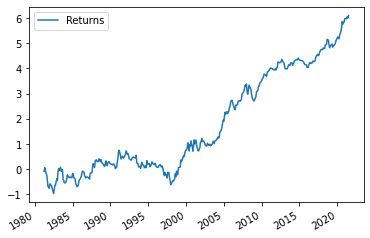

In [35]:
excess_returns_cum = excess_returns.cumsum()
excess_returns_cum.plot.line()

In [36]:
#Regression Section
data = ff_factors.join(excess_returns).dropna()

y = data[["Returns"]] 
x = data[["Mkt-RF","SMB","HML"]]


ols = sm.OLS(y,x)

result = ols.fit()
betas = result.params
print(betas)

Mkt-RF    1.180133
SMB       0.218137
HML      -0.682786
dtype: float64


In [37]:
latest_ff_factors = ff_factors.tail(1).to_dict('r')[0]

RRR = latest_ff_factors['RF']+ betas["Mkt-RF"] * latest_ff_factors["Mkt-RF"]+ betas["SMB"] * latest_ff_factors["SMB"]+ betas["HML"] * latest_ff_factors["HML"]

print(f"Required rate of return is: {RRR}")

Required rate of return is: 0.08940485295302046


/Users/macbookair/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:1549: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(
